In [1]:
#Wir importieren die benötigten Bibliotheken
import importlib as imp
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import sympy
import matplotlib.pyplot as plt

import pysim
import mimo
import gantry as module_gantry #avoid name-clash

#Liste der Ruhelagen
equis=[[0.0,0.0],[0.0,0.3],[0.8,0.0],[0.8,0.3]]

# 1 Modell des Portals
## 1.1 Nichtlineares Modell 
### 1.1.1 Modellgleichungen
\begin{gather}
\newcommand{\vect}[1]{\boldsymbol{#1}}\small
\left[\begin{matrix}m + M & 0 & - m \left(x_1 \sin{\left(\varphi \right)} + x_2 \cos{\left(\varphi \right)}\right)\\0 & m + M & m \left(x_1 \cos{\left(\varphi \right)} - x_2 \sin{\left(\varphi \right)}\right)\\- m \left(x_1 \sin{\left(\varphi \right)} + x_2 \cos{\left(\varphi \right)}\right) & m \left(x_1 \cos{\left(\varphi \right)} - x_2 \sin{\left(\varphi \right)}\right) & J_{R} + m \left(x_1^{2} + x_2^{2}\right)\end{matrix}\right]\begin{bmatrix}\dot{z}_1\\\dot{z}_2\\\dot\varphi\end{bmatrix}=-\left[\begin{matrix}m \cos{\left(\varphi \right)} & - m \sin{\left(\varphi \right)}\\m \sin{\left(\varphi \right)} & m \cos{\left(\varphi \right)}\\- m x_2 & m x_1\end{matrix}\right]\begin{bmatrix}\dot x_1\\\dot x_2\end{bmatrix}+\begin{bmatrix}p_1\\p_2\\p_\varphi\end{bmatrix}\\
\begin{bmatrix}\dot{p}_1\\\dot{p}_2\\\dot{p}_\varphi\end{bmatrix}=\left[\begin{matrix}- 4 k z_1\\- 4 k z_2\\(- \dot{\varphi} \dot{z}_1 m x_1 - \dot{\varphi} \dot{z}_2 m x_2- \dot{z}_1 \dot{x}_2 m  + \dot{x}_1 \dot{z}_2 m)\cos{\left(\varphi \right)} + (\dot{\varphi} \dot{z}_1 m x_2 - \dot{\varphi} \dot{z}_2 m x_1 - \dot{z}_1 \dot{x}_1 m  - \dot{z}_2 \dot{x}_2 m  - 4 k l^{2})\sin{\left(\varphi \right)} \end{matrix}\right]\\
\ddot{x}_1={u}_1\\
\ddot{x}_2={u}_2
\end{gather}
Als Zustand für die Implementierung soll der Vektor
\begin{equation}\boldsymbol{x}=
\begin{bmatrix}
x_1\\x_2\\x_3\\x_4\\x_5\\x_6\\x_7\\x_8\\x_9\\x_{10}
\end{bmatrix}=\begin{bmatrix}
x_1\\x_2\\z_1\\z_2\\\varphi\\ \dot{x}_1\\\dot{x}_2\\p_1\\p_2\\ p_{\varphi}
\end{bmatrix}
\end{equation}
verwendet werden.
Zur Auswertung der Zustandsdifferentialgleichungen ist es sinnvoll, zunächst $\dot{z}_1$, $\dot{z}_2$, und $\dot\varphi$ zu berechnen und dann in die Gleichungen für $\dot{p}_1$, $\dot{p}_2$, und $\dot{p}_\varphi$  einzusetzen, um Mehrfachauswertungen von längeren Ausdrücken zu vermeiden.

### 1.1.2. Nichtlineares Modell

#### Test des nichtlinearen Modells

Lösen vor Ausführung der Zellen die Aufgabe 1a).

In [20]:
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Modell anlegen
gantry=Gantry()

#Auswerten
gantry.verify_model('testdata.pckl')

Maximaler absoluter Fehler in Modellgleichung (euklidische Norm): 543.4346812562995
Maximaler relativer Fehler in Modellgleichung (euklidische Norm): 0.9999999230522288
Maximaler absoluter Fehler in Ausgang accell_frame (euklidische Norm): 50.07315903259237
Maximaler relativer Fehler in Ausgang accell_frame (euklidische Norm): 1.0
Maximaler absoluter Fehler in Ausgang gyro_frame (euklidische Norm): 0.6938911283027032
Maximaler relativer Fehler in Ausgang gyro_frame (euklidische Norm): 1.0
Maximaler absoluter Fehler in Ausgang position_axis (euklidische Norm): 1.409171772578883
Maximaler relativer Fehler in Ausgang position_axis (euklidische Norm): 1.0
Maximaler absoluter Fehler in Ausgang position_total (euklidische Norm): 2.161120873859835
Maximaler relativer Fehler in Ausgang position_total (euklidische Norm): 1.0
Maximaler absoluter Fehler in Ausgang state (euklidische Norm): 0.0
Maximaler relativer Fehler in Ausgang state (euklidische Norm): 0.0


#### Simulation des nichtlinearen Modells

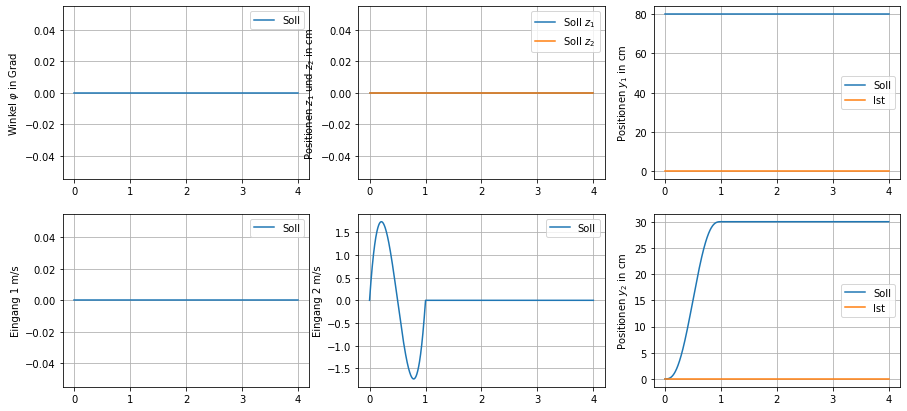

In [3]:
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Einfacher polynomialer Übergang für den Schlitten
from gantry import RigidTrajectory 

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results

#Modell anlegen
gantry=Gantry()

# Anfangs- und Endwerte für die Schlittenposition (absolut) 
ya = np.array(equis[2])
yb = np.array(equis[3])

#Anfangsbedingungen
x0 = np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=4*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,1000)

trajectory_rigid=RigidTrajectory(ya,yb,T,[2,2])

#Regler ist Steuerung
gantry.connect("accell_axis", trajectory_rigid, "u_ref")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,  #Zeit
             (x,),#Zustand
             (trajectory_rigid.input(t_eval),),#Eingangsverläufe (Soll, Ist)
                         (trajectory_rigid.state(t_eval),
                          gantry.output(t_eval,x,'position_total')) #Absolutposition Schlitten (Soll,Ist) 
            )

## 1.2 Lineares Modell des Systems

Lösen Sie vor Ausführung des nachfolgenden Codes die Aufgabe 1b). Dokumentieren Sie Ihre Überlegungen in dieser Zelle.

### 1.2.1. Modellgleichungen

##### Ruhelage:

Alle Größen verschwinden identisch bis auf 
\begin{align}
x_1=x_{10}\\
x_2=x_{20}\\
\end{align}

##### Ergänzen Sie bitte hier die linearisierten Gleichungen (Aufgabe 1b)

\begin{align}
\dot{\tilde{x}}_1 &= \tilde{x}_6 \\
\dot{\tilde{x}}_2 &= \tilde{x}_7 \\
\mathbf{M}(\bar{x})
\begin{bmatrix}
\dot{\tilde{z}}_1  \\ \dot{\tilde{z}}_2 \\ \dot{\tilde{\varphi}}
\end{bmatrix}
&= -
\begin{bmatrix}
m & 0 \\
0 & m \\
-m \overline{x}_2 & m \overline{x}_1
\end{bmatrix}
\begin{bmatrix}
\tilde{x}_6 \\ \tilde{x}_7
\end{bmatrix}
+
\begin{bmatrix}
\tilde{p}_1  \\ \tilde{p}_2 \\ \tilde{p}_\varphi
\end{bmatrix} \\
\dot{\tilde{x}}_6 &= \tilde{u}_1 \\
\dot{\tilde{x}}_7 &= \tilde{u}_2 \\
\dot{\tilde{p}}_1 &= -4k \tilde{z}_1 \\
\dot{\tilde{p}}_2 &= -4k \tilde{z}_2 \\
\dot{\tilde{p}}_{\varphi} &= -4k l^2 \tilde{\varphi} \\
\end{align}

\begin{align}
\tilde{y}_1 = \tilde{x}_1 + \tilde{z}_1 - \overline{x}_2 \cdot \tilde{\varphi} \\
\tilde{y}_2 = \tilde{x}_2 + \tilde{z}_2 + \overline{x}_1 \cdot \tilde{\varphi}
\end{align}

**Massenmatrix:**

$$
\mathbf{M}(\bar{x}) =
\begin{bmatrix}
m + M & 0 & - m \bar{x}_2\\
0 & m + M & m \bar{x_1} \\
- m \bar{x}_2 & m \bar{x_1} & J_{R} + m \left(\overline{x}_1^{2} + \overline{x}_2^{2}\right)
\end{bmatrix}
$$


In [19]:
#Modell linearisieren und Linearisierung überprüfen
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Einfacher Polynomialer Übergang für den Schlitten
from gantry import RigidTrajectory 

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results

#Modell anlegen
gantry=Gantry()

#Linearisierungspunkt 4.Ruhelage
equi_lin=equis[3]

#Berechnung der Linearisierung
gantry_lin=gantry.linearize(equi_lin)

#Prüfen der Linearisierung
A,B,C,D=gantry.verify_linearization(gantry_lin)

Maximaler absoluter Fehler in Matrix A Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix A Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_gyro_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_gyro_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 2.8755664516211255e-11.
Maximaler relativer Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 2.8755664515384365e-11.
Maxi

### 1.2.2 Simulation des linearen Modells

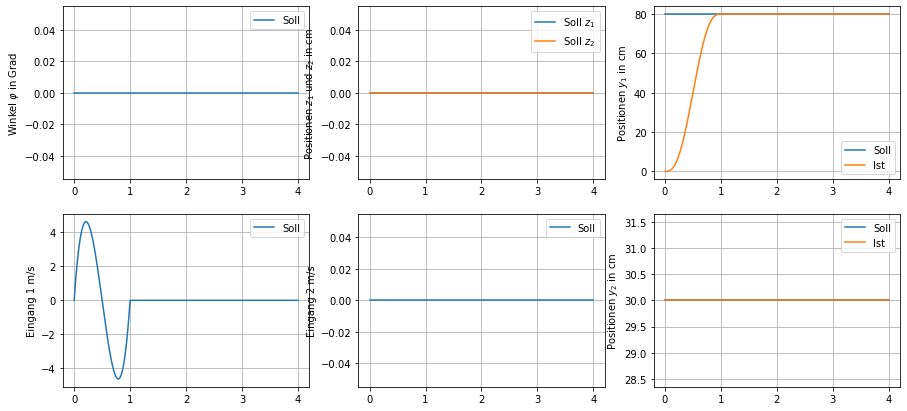

In [5]:
import gantry as module_gantry
imp.reload(module_gantry)

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results


#Anfangsbedingungen
x0 = np.array([equis[1][0],equis[1][1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0




#Simulationszeit
T_sim=4*T

#Steuerung definieren
trajectory_rigid=RigidTrajectory(equis[1],equis[3],T,[2,2])

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Eingang mit Steuerung verbinden 
gantry_lin.connect("accell_axis", trajectory_rigid, "u_ref")

#Simulation
res = solve_ivp(gantry_lin.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-8,rtol=1e-7 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,(x,),(trajectory_rigid.input(t_eval),),
             (gantry_lin.output(t_eval,x,'position_total'),
              trajectory_rigid.state(t_eval)))

# 2 Regelungs- und Steuerungsentwurf

## 2.1 Steuerungsentwurf 

In [6]:
#Module neu laden
import gantry as module_gantry
import pysim 
imp.reload(module_gantry)
imp.reload(pysim)

#Trajektorienplanung
from pysim import ContinuousFlatnessBasedTrajectory, ContinuousLinearizedSystem

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results, Gantry

#Modell anlegen
gantry=Gantry()

#Übergangszeit für Trajektorie
T = 1.0

#Linearisierungspunkt 4.Ruhelage
equi_lin=equis[3]

#Modell definieren
gantry_nl=Gantry()

#Linearisiertes Modell
gantry_lin=gantry_nl.linearize(equi_lin)

equis_trj={"position_total":{"start":equis[1],"final":equis[3]}}

#Generiere Solltrajektorien für das linearisierte System
trajectory=gantry_lin.rest_to_rest_trajectory(equis_trj,T,(4,6))


Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

### Simulation der Steuerung mit linearem oder nichtlinearem Modell

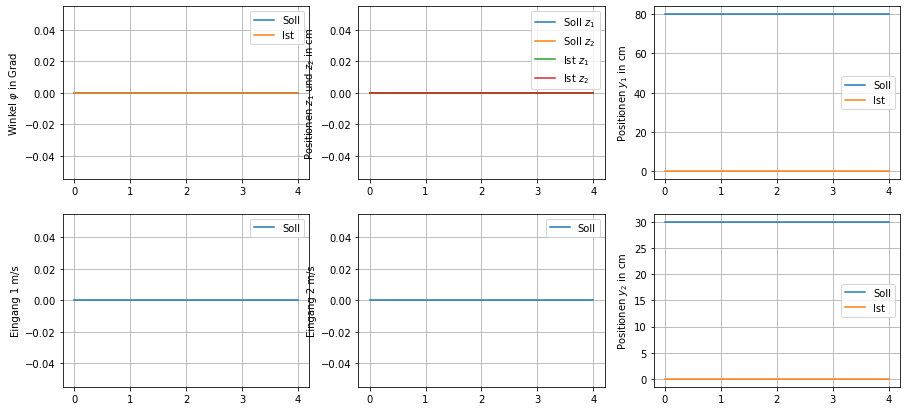

In [7]:
#Anfangszustand
x0=trajectory.state(0).flatten()

#Simulationszeit
Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

#Lineares oder nichtlineares Modell
linear = False
if linear:
    gantry=gantry_lin
else:
    gantry=gantry_nl

# Steuerung einbauen
gantry.connect('accell_axis',trajectory,'u_ref')

#Simlation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
a=plot_results(t_eval,
               (trajectory.state(t_eval),res.y),
               (trajectory.input(t_eval),),
               (trajectory.output(t_eval,'position_total'),gantry.output(t_eval,x,'position_total')))

## 2.2 Reglerentwurf mittels Eigenwertvorgabe 

### Berechnen der Reglerverstärkungen und Simulation des geschlossenen Regelkreises

In [8]:
import warnings
warnings.filterwarnings("error")

#importiere benötigte Funktion
imp.reload(module_gantry)
imp.reload(pysim)
from gantry import Gantry
from pysim import ContinuousFlatnessBasedTrajectory, LinearStateFeedback

#Regler definieren 
######-------!!!!!!Aufgabe!!!!!!-------------########
##Hier bitte die Reglerverstärkung berechnen
K_pole_placement=np.zeros([2,10])

######-------!!!!!!Aufgabe Ende !!!!!!-------------########


### Simulation des geschlossenen Regelkreises

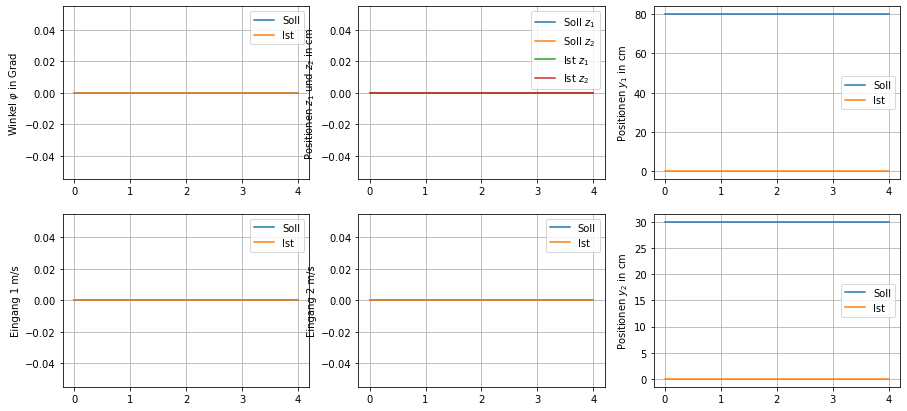

In [9]:
#Anfangszustand
x0=trajectory.state(0).flatten()
#x0[0]=x0[0]+0.1
Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

linear=False
if linear:
 gantry=gantry_lin
else:
 gantry=gantry_nl

#Regler definieren 
controller=LinearStateFeedback(K_pole_placement)

#System verschalten
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",gantry,"state")
gantry.connect("accell_axis",controller,"u")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,
             (trajectory.state(t_eval),res.y),
             (trajectory.input(t_eval),controller.output(t_eval,x)),
             (trajectory.output(t_eval,"position_total"),gantry.output(t_eval,x,"position_total")))

## 2.3 LQR Entwurf

### 2.3.1 Berechnen der Reglerverstärkung

#### Ergänzen Sie hier Ihre Überlegungen zu Aufgabe 2e) und passen Sie den Code der nächsten Zelle entsprechend an.

In [10]:
import gantry as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

#lineares Modell
from pysim import LinearizedSystem

K_lqr=np.zeros((2,10))

print("Reglerverstärkung:")
display(sympy.Matrix(K_lqr.round(3)))


print("Probe (Eigenwerte geschlossener Kreis):")
display(sympy.Matrix(np.linalg.eigvals(gantry_lin.A()-gantry_lin.B()@K_lqr).round(3)).transpose())

Reglerverstärkung:


Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Probe (Eigenwerte geschlossener Kreis):


Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 2.3.2. Simulationsstudien

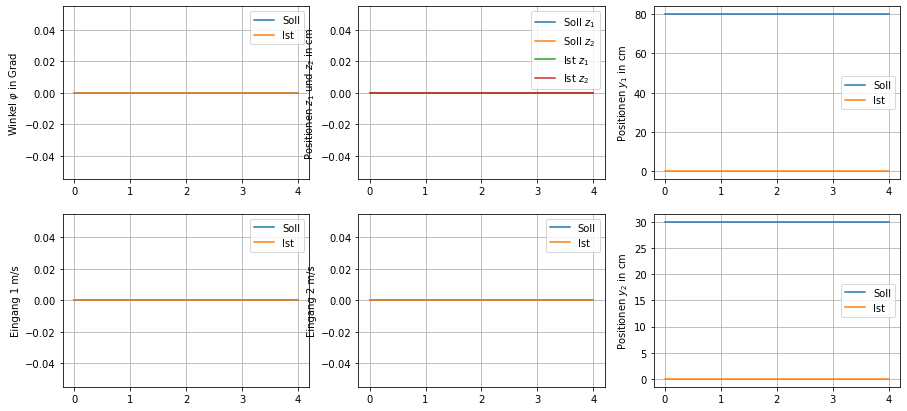

In [11]:
#Reglerverstärkung setzen
controller.set_gain(K_lqr)


#Anfangszustand
x0=trajectory.state(0).flatten()

Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,1000)
linear=False
if linear:
 gantry=gantry_lin
else:
 gantry=gantry_nl

#System verschalten
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",gantry,"state")
gantry.connect("accell_axis",controller,"u")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,
            (trajectory.state(t_eval),res.y),
            (trajectory.input(t_eval),controller.output(t_eval,x)),
            (trajectory.output(t_eval,"position_total"),gantry.output(t_eval,x,"position_total")))

# 3 Beobachterentwurf

#### Fügen Sie hier hier Ihre überlegungen zu Teilaufgabe 3a) ein

Um zu überprüfen ob der Zustand vollständig Rekonstruierbar bzw. vollständig Beobachtbar ist, müssen wir einer der folgenden äquivalenten Bedigungen Prüfen.

1. Die Kalmansche Beobachtbarkeitsmatrix besitzt den Rang $n$.
2. Die Gramsche Beobachtbarkeitsmatrix ist regulär.
3. Die Beobachtbarkeitsmatrix nach Hautus hat für alle $z \in \mathbb{C}$ den Rang 

Ein LTI-System ist immer Erreichbar wenn es auch Beobachtbar ist und umgekehrt. Für die Überprüfung wir die kalmansche Beobachtbarkeitsmatrix mit Hilfe der Control-Toolbox verwendet.

In [33]:
import control as ctrl

A = gantry_lin.A().copy()
C = gantry_lin.C('position_axis').copy()

O = ctrl.obsv(A, C)

print('Rang der Beobachtbarkeitsmatrix:')
print(np.linalg.matrix_rank(O))

Rang der Beobachtbarkeitsmatrix:
4


Der Rang der Matrix entspricht nicht der Zustandsdimension. Das System ist somit nicht Rekonstruierbar.

## 3.1 Adaptiertes Modell

### 3.1.1. Zusätzliche Sensorik

#### Fügen Sie hier hier Ihre Überlegungen zu Teilaufgabe 3b) ein. 
Die Winkelgeschwindigkeit kann durch die Annahme $y_{m,3}=\dot{\varphi}$ direkt aus der Modellgleichung bestimmt werden.\
Die Beschleunigungen $\bar{u}_1 = \ddot{z}_1$ und $\bar{u}_2 = \ddot{z}_2$ können durch einmaliges Ableiten der Modellgleichung nach der Zeit bestimmt werden.

Modellgleichung:
\begin{align}
\mathbf{\dot{z}} = \begin{bmatrix}\dot{z}_1  \\ \dot{z}_2 \\
\dot{\varphi}\end{bmatrix};
\mathbf{x} = \begin{bmatrix}x_6  \\ x_7\end{bmatrix};
\mathbf{N} = \begin{bmatrix}
m & 0 \\
0 & m \\
-m \overline{x}_2 & m \overline{x}_1
\end{bmatrix};
\mathbf{x} = \begin{bmatrix}x_6  \\ x_7\end{bmatrix};
\mathbf{p} = \begin{bmatrix}p_1  \\ p_2 \\p_{\varphi}\end{bmatrix}
\end{align}\
\begin{align}
\mathbf{M} \mathbf{\dot{z}} = - \mathbf{N} \mathbf{x} + \mathbf{p}
\end{align}

Winkelgeschwindigkeit $\dot{\varphi}$:
\begin{align}
\begin{bmatrix}\dot{z}_1  \\ \dot{z}_2 \\
\dot{\varphi}\end{bmatrix} = \mathbf{\dot{z}} =\mathbf{M^{-1}} (- \mathbf{N} \mathbf{x} + \mathbf{p})
\end{align}

Beschleunigungen $\bar{u}_1 = \ddot{z}_1$ und $\bar{u}_2 = \ddot{z}_2$: ( Ableiten mittels Produktregel)

\begin{align}
\mathbf{M} \mathbf{\ddot{z}} + \mathbf{\dot{M}} \mathbf{\dot{z}} = - \mathbf{\dot{N}} \mathbf{\dot{x}}- \mathbf{N} \mathbf{\ddot{x}}+ \mathbf{p}
\end{align}

\begin{align}
\begin{bmatrix}\ddot{z}_1  \\ \ddot{z}_2 \\
\ddot{\varphi}\end{bmatrix} = \mathbf{\ddot{z}} = \mathbf{M^{-1}} (-\mathbf{\dot{M}} \dot{z} - \mathbf{\dot{N}} \mathbf{\dot{x}}- \mathbf{N} \mathbf{\ddot{x}}+ \mathbf{p})
\end{align}

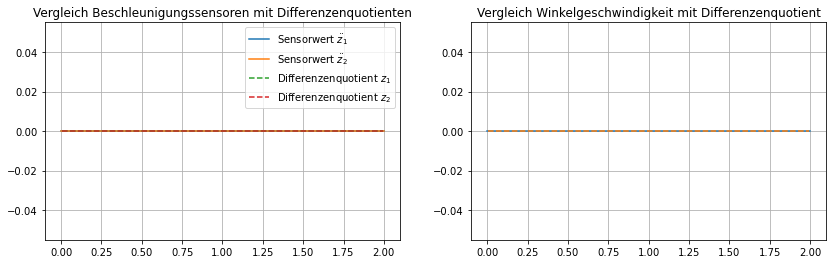

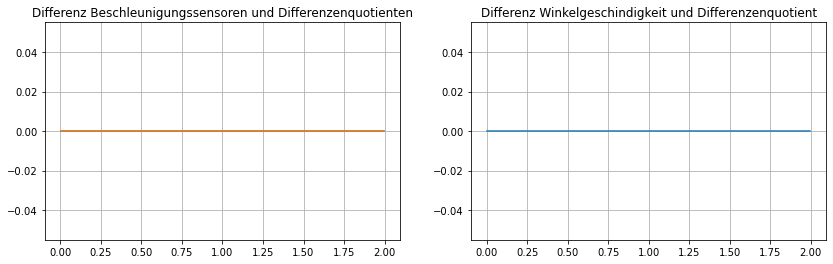

In [12]:
#Modell neu laden
import gantry as module_gantry
import pysim
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, plot_results, RigidTrajectory;

##Nichtlineares Modell initialisieren
gantry_nl=Gantry()
gantry_lin=gantry.linearize(equi_lin)

linear=False

if linear:
    gantry=gantry_lin
else:
    gantry=gantry_nl

#Starr geplante Trajektorie
trajectory_rigid=RigidTrajectory(equis[1],equis[3],T,[2,2])

#System Verschalten
gantry.connect('accell_axis',trajectory,'u_ref')

#Anfangsbedingungen
x0 = np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=2*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Simulieren
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustand auslesen
x=res.y

##Sensoren auswerten 
ddz=gantry.output(t_eval,x,'accell_frame')
dphi=gantry.output(t_eval,x,'gyro_frame')

##Differenzenquotienten Beschleunigung berechnen
dt=t_eval[1]-t_eval[0]
ddz_approx=(x[2:4,2:]-2*x[2:4,1:-1]+x[2:4,0:-2])/dt**2
dphi_approx=(x[4,2:]-x[4,0:-2])/dt/2
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.grid()
plt.plot(t_eval,ddz[0,:],label="Sensorwert $\\ddot{z}_1$")
plt.plot(t_eval,ddz[1,:],label="Sensorwert $\\ddot{z}_2$")
plt.plot(t_eval[1:-1], ddz_approx[0,:], '--', label = "Differenzenquotient $z_1$")
plt.plot(t_eval[1:-1], ddz_approx[1,:], '--', label = "Differenzenquotient $z_2$")
plt.legend()
plt.title("Vergleich Beschleunigungssensoren mit Differenzenquotienten")

plt.subplot(1,2,2)
plt.grid()
plt.plot(t_eval,dphi[0,:],label="Sensorwert $\\ddot{\varphi}$")
plt.plot(t_eval[1:-1],dphi_approx,'--', label="Differenzenquotient $\\ddot{\varphi}$")
plt.title("Vergleich Winkelgeschwindigkeit mit Differenzenquotient")

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.grid()
plt.plot(t_eval[1:-1], ddz_approx[0,:]-ddz[0,1:-1], label = "Fehler $\\ddot{z}_1$")
plt.plot(t_eval[1:-1], ddz_approx[1,:]-ddz[1,1:-1], label = "Fehler $\\ddot{z}_2$")
plt.title("Differenz Beschleunigungssensoren und Differenzenquotienten")
plt.subplot(1,2,2)
plt.grid()
plt.plot(t_eval[1:-1], dphi_approx[:]-dphi[0,1:-1], label = "Fehler $\\dot{\varphi}$")
plt.title("Differenz Winkelgeschindigkeit und Differenzenquotient")
plt.show()


### 3.1.2. Beobachtermodell


#### Fügen Sie hier hier Ihre Überlegungen zu Teilaufgabe 3c) ein.
Zum Aufstellen des neuen Zustandsraummodells werden die Matrizen so umgestellt, dass die Beschleunigungen des Schlittens $ \ddot{x}_1 $ und $ \ddot{x}_2 $ sowie die Windelbeschleunigung der Platte $ \ddot{\varphi} $ in einem Vektor stehen, sodass zu dessen Berechnung nach diesem umgestellt werden kann. Die nun gemessenen Beschleunigungen $ \ddot{z}_1 , \ddot{z}_2 $ werden als Eingang verwendet.  

\begin{align}
\dot{x}_1 &= x_6 \\
\dot{x}_2 &= x_7 \\
\dot{z}_1 &= x_8 \\
\dot{z}_2 &= x_9 \\
\dot{\tilde{\varphi}} &= x_{10} \\
\mathbf{M}(x)
\begin{bmatrix}
\ddot{x}_1  \\ \ddot{x}_2 \\ \ddot{\varphi}
\end{bmatrix}
&= \dot{p} - \dot{M}(x)
\begin{bmatrix}
x_6 \\
x_7 \\
x_{10} \\
\end{bmatrix}
-
M_2(x)
\begin{bmatrix}
\ddot{z}_1  \\ \ddot{z}_2 
\end{bmatrix}
-
\dot{M}_2(x)
\begin{bmatrix}
\dot{z}_1  \\ \dot{z}_2 
\end{bmatrix}\\
\ddot{z}_1 &= u_1 \\
\ddot{z}_2 &= u_2 \\
\end{align}


**Massenmatrizen:**
$$
\mathbf{M}(\bar{x}) = m 
\begin{bmatrix}
\cos(\varphi) & -\sin(\varphi) & - (x_1 \sin(\varphi) + x_2 \cos(\varphi))\\
\sin(\varphi) & \cos(\varphi) & (x_1 \cos(\varphi) - x_2 \sin(\varphi)) \\
- x_2  &  x_1 & J_{R}/m + \left(x_1^{2} + x_2^{2}\right)
\end{bmatrix}
$$


$$
\mathbf{M}_2(x) =
\begin{bmatrix}
m+M & 0 \\
0 & m+M\\
-m(x_1 \sin(\varphi) + x_2 \cos(\varphi) & m(x_1 \cos(\varphi) - x_2 \sin(\varphi)
\end{bmatrix}
$$

$$
\mathbf{\dot{M}}_2(x) =
\begin{bmatrix}
0 & 0 \\
0 & 0\\
-m(\dot{x}_1 \sin(\varphi) + \dot{x}_2 \cos(\varphi) + x_1 \cos(\varphi) \dot{\varphi}- x_2 \sin(\varphi) \dot{\varphi}& 
-m(\dot{x}_1 \cos(\varphi) - \dot{x}_2 \sin(\varphi) - x_1 \sin(\varphi) \dot{\varphi}- x_2 \cos(\varphi) \dot{\varphi}
\end{bmatrix}
$$

Aus Platzgründen wird die Ableitung der Massenmatrix $M$ sowie der Vektor $ \dot{p} $ hier nicht dargestellt. Diese ist sind im Ordner .assets als Bilddatei dargestellt.

**Umstellen nach dem zu berechnenden Vektor**

\begin{align}
\begin{bmatrix}
\ddot{x}_1  \\ \ddot{x}_2 \\ \ddot{\varphi}
\end{bmatrix}
&= 
\mathbf{M^{-1}}(x) \Bigg(\dot{p} - \dot{M}(x)
\begin{bmatrix}
x_6 \\
x_7 \\
x_{10} \\
\end{bmatrix}
-
M_2(x)
\begin{bmatrix}
\ddot{z}_1  \\ \ddot{z}_2 
\end{bmatrix}
-
\dot{M}_2(x)
\begin{bmatrix}
\dot{z}_1  \\ \dot{z}_2 
\end{bmatrix} \Bigg) \\
\end{align}

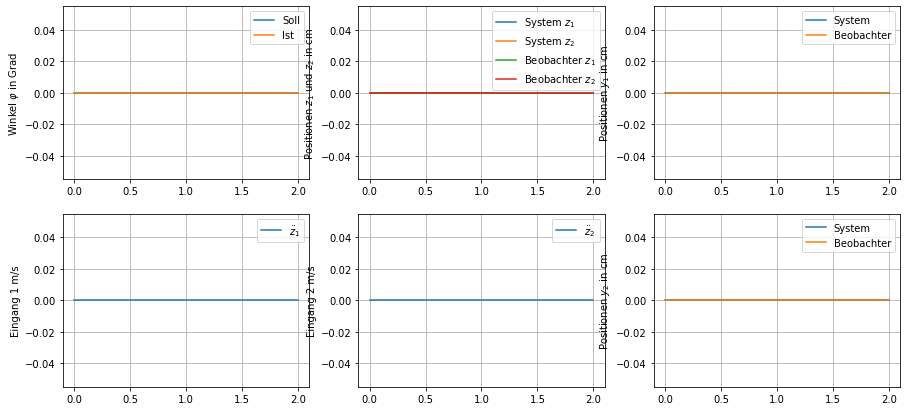

In [13]:
#Modell neu laden
import gantry as module_gantry
import pysim as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserverModel, plot_results, RigidTrajectory;
from pysim import CompoundSystem

#Modell des Brückenkrans initialisieren
gantry_nl=Gantry()
gantry=gantry_nl

#Modell des Beobachters initialisieren
observer_model=GantryObserverModel(gantry_nl);

##Gesamtsystem bauen
observed_gantry=CompoundSystem()
observed_gantry.add_system(gantry,"Systemmodell")
observed_gantry.add_system(observer_model,"Beobachter")
observed_gantry.add_system(trajectory,"Steuerung")

gantry.connect('accell_axis',trajectory,'u_ref')
observer_model.connect('accell_frame',gantry,'accell_frame')

# Anfangs- und Endwerte für die Schlittenposition (absolut) 
ya = equis[0]
yb = equis[1]

#Anfangsbedingungen
trajectory_rigid=RigidTrajectory(ya,yb,T,[2,2])

#Anfangsbedingungen für beide Systeme in Dictionary
x0_ = {gantry.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0]),
       observer_model.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])}

#Anfangsbedingungen in Vektor umwandeln
x0=observed_gantry.assemble_state(x0_)

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=2*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Wrapper für rechte Seite der Differentialgleichung
res = solve_ivp(observed_gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustände der Teilsysteme auspacken
x=observed_gantry.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

#Ergebnisse Plotten
plot_results(t_eval,
             (x_sys,x_obs),
             (gantry.output(t_eval,x,'accell_frame'),),
             (gantry.output(t_eval,x,'position_total'),observer_model.output(t_eval,x,'position_total')))

ax=plt.subplot(2,3,2)
ax.legend(["System $z_1$", "System $z_2$", "Beobachter $z_1$", "Beobachter $z_2$"])
ax=plt.subplot(2,3,4)
ax.legend(["$\\ddot{z}_1$"])
ax=plt.subplot(2,3,5)
ax.legend(["$\\ddot{z}_2$"])
ax=plt.subplot(2,3,3)
ax.legend(["System","Beobachter"])
ax=plt.subplot(2,3,6)
ax.legend(["System","Beobachter"])

## 3.2 Beobachtbarkeit
### Linearisierung

#### Ergänzen Sie Ihre Überlegungen zu Teilaufgabe 3d hier

In [14]:
#Linearisiertes Modell berechnen
observer_model_lin=observer_model.linearize(equis[0])

#Prüfen der Linearisierung
observer_model.verify_linearization(observer_model_lin);

Maximaler absoluter Fehler in Matrix A Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix A Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_gyro_frame Zeile 1, Spalte 10 beträgt 1.0.
Maximaler relativer Fehler in Matrix C_gyro_frame Zeile 1, Spalte 10 beträgt 1.0.
Maximaler absoluter Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 1.0.
Maximaler relativer Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 1.0.
Maximaler absoluter Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 1.0.
Maximaler relativer Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 1.0.
Maximaler absoluter Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix B_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix B_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix D_{

### Beobachtbarkeit

#### Ergänzen Sie Ihre Überlegungen zu Teilaufgabe 3e) und 3f) hier

In [15]:
import mimo
imp.reload(mimo)

#Analyse der Beobachtbarkeit für die verschiedene Arbeitspunkte
for equi in equis:
    #Linearisiertes Modell berechnen
    _observer_model_lin=observer_model.linearize(equi)

    #Systematrizen aufstellen
    _A=_observer_model_lin.A()

    _C_full=np.vstack((_observer_model_lin.C("position_axis"),_observer_model_lin.C("gyro_frame")))
    
    _C_axis=_observer_model_lin.C("position_axis")

    print("Ruhelage:", equi)
    #Beobachtbarkeitsmatrix aufstellen
    O=mimo.controllability_matrix(_A.transpose(),_C_axis.transpose()).transpose()
    print("Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition:", np.linalg.matrix_rank(O))

    #Berechnung der Kronecker-Indizes
    kroneckers=mimo.kronecker(_A.transpose(),_C_axis.transpose())
    print("Mögliche Kronecker-Indizes:", kroneckers)

    #Beobachtbarkeitsmatrix aufstellen
    O=mimo.controllability_matrix(_A.transpose(),_C_full.transpose()).transpose()
    print("Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops:", np.linalg.matrix_rank(O))
 
    #Berechnung der Kronecker-Indizes
    kroneckers=mimo.kronecker(_A.transpose(),_C_full.transpose())
    print("Mögliche Kronecker-Indizes:", kroneckers)

    print()
        
#np.linalg.svd(Oa, compute_uv=False)

Ruhelage: [0.0, 0.0]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 0
Mögliche Kronecker-Indizes: [0. 0.]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 0
Mögliche Kronecker-Indizes: [0. 0. 0.]

Ruhelage: [0.0, 0.3]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 0
Mögliche Kronecker-Indizes: [0. 0.]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 0
Mögliche Kronecker-Indizes: [0. 0. 0.]

Ruhelage: [0.8, 0.0]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 0
Mögliche Kronecker-Indizes: [0. 0.]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 0
Mögliche Kronecker-Indizes: [0. 0. 0.]

Ruhelage: [0.8, 0.3]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 0
Mögliche Kronecker-Indizes: [0. 0.]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 0
Mögliche Kronecker-Indizes: [0. 0. 0.]



## 3.3. Beobachterentwurf

#### Ergänzen Sie hier Ihre Überlegungen zu den Teilaufgaben 3g) und 3h) und ergänzen Sie den gegebenen Code in der folgenden Zelle entsprechend

In [16]:
import mimo
imp.reload(mimo)

#Linearisiertes Modell berechnen
observer_model_lin=observer_model.linearize(equis[0])

#Systematrizen für Beobachterentwurf generieren
A=observer_model_lin.A()
B=observer_model_lin.B()
C=np.vstack((observer_model_lin.C("position_axis"),observer_model_lin.C("gyro_frame")))

#Beobachterverstärkungen festlegen
observer_gain=np.zeros((10,3))
                       
#Prüfen der Eigenwerte des geschlossenen Regelkreises für die weiteren Ruhelagen
for _equi in equis:
    _observer_model_lin=observer_model.linearize(_equi)
    A=_observer_model_lin.A()
    B=_observer_model_lin.B()
    C=np.vstack([_observer_model_lin.C("position_axis"),_observer_model_lin.C("gyro_frame")])
    print("Eigenwerte Beobachterfehlersystem in Ruhelage: [" + str(_equi[0])+","+str(_equi[1])+"]")
    display(sympy.Matrix(np.linalg.eigvals((A-observer_gain@C)).round(3)).transpose())
    

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.0,0.0]


Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.0,0.3]


Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.8,0.0]


Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.8,0.3]


Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Simulation des Systems mit Beobachter

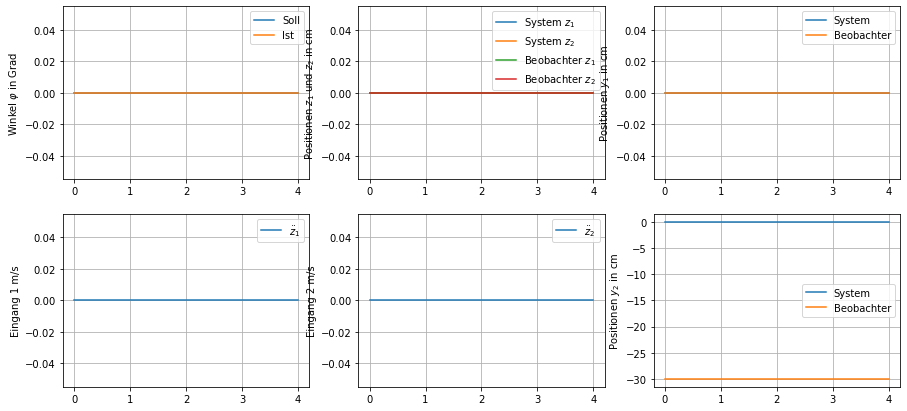

In [17]:
#Module neu laden
import pysim
import gantry as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserver, plot_results, RigidTrajectory
from pysim import CompoundSystem

#Design- und Simulationsmodelle generieren
gantry_sim_nl=Gantry()
gantry_design_nl=Gantry()

#Modellfehler einbauen
model_error=0.1 # relativer Fehler
gantry_sim_nl.k=(1.0+model_error)*gantry_sim_nl.k

#Lineare Modelle generieren
gantry_sim_lin=gantry_sim_nl.linearize(equis[0])
gantry_design_lin=gantry_design_nl.linearize(equis[0])

#Design- und Simulationsmodell auswählen (linear oder nichtlinear)
gantry_design=gantry_design_nl
gantry_sim=gantry_sim_nl

# Solltrajektorie generieren 
ya = equis[1]
yb = equis[3]
trajectory=RigidTrajectory(ya,yb,T,[2,2])

#Beobachter initialisieren
observer=GantryObserver(gantry_design);
observer.set_gain(observer_gain)

#System zusammensetzen
observed_system=CompoundSystem()
observed_system.add_system(gantry_sim,"Systemmodell")
observed_system.add_system(observer,"Beobachter")
observed_system.add_system(trajectory,"Steuerung")

#System verschalten
gantry_sim.connect('accell_axis',trajectory,'u_ref')
observer.connect('accell_frame',gantry_sim,'accell_frame')
observer.connect('position_axis_sys',gantry_sim,'position_axis')
observer.connect('gyro_frame_sys',gantry_sim,'gyro_frame')


#Anfangsbedingungen für Teilsysteme
x0_ = {gantry.get_name():np.array([-0.0,-0.3,0.0,0,0,0,0,0,0,0]),
       observer.get_name():np.array([-0.0,-0.3,0,0,0,0,0,0,0,0])}

#Vektor von Anfangsbedingungen generieren
x0=observed_system.assemble_state(x0_)

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=4*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Simulieren
res = solve_ivp(observed_system.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=observed_system.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

plot_results(t_eval,
             (x_sys,x_obs),
             (gantry.output(t_eval,x,'accell_frame'),),
             (gantry.output(t_eval,x,'position_total'),observer.output(t_eval,x,'position_total')))

ax=plt.subplot(2,3,2)
ax.legend(["System $z_1$", "System $z_2$", "Beobachter $z_1$", "Beobachter $z_2$"])
ax=plt.subplot(2,3,4)
ax.legend(["$\\ddot{z}_1$"])
ax=plt.subplot(2,3,5)
ax.legend(["$\\ddot{z}_2$"])
ax=plt.subplot(2,3,3)
ax.legend(["System","Beobachter"])
ax=plt.subplot(2,3,6)
ax.legend(["System","Beobachter"])

### Simulation geschlossener Regelkreis

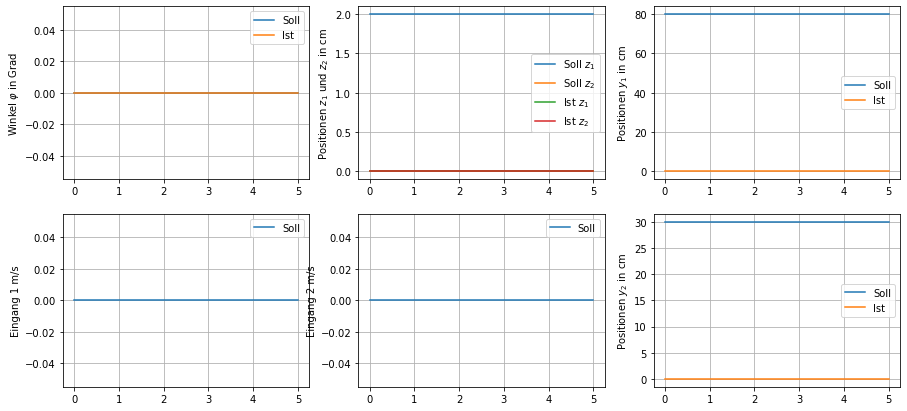

In [18]:
#Modell neu laden
import gantry as module_gantry
import pysim
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserver, plot_results, RigidTrajectory
from pysim import LinearStateFeedback, CompoundSystem, ContinuousFlatnessBasedTrajectory

#Nichtlineare Modelle initialisieren
gantry_sim_nl=Gantry()
gantry_design_nl=Gantry()

#Modellfehler
model_error=0.1 # relativer Fehler
gantry_sim_nl.k=(1.0+model_error)*gantry_sim_nl.k

#Lineare Modelle generieren
gantry_sim_lin=gantry_sim_nl.linearize(equi)
gantry_design_lin=gantry_design_nl.linearize(equi)

#Design- und Simulationsmodelle festlegen
gantry_design=gantry_design_nl
gantry_sim=gantry_sim_nl

# Solltrajektorie generieren 
ya = equis[1]
yb = equis[3]
equis_trj={"position_total":{"start":equis[1],"final":equis[3]}}
trajectory=gantry_design_lin.rest_to_rest_trajectory(equis_trj,T,(4,6))

#Regler definieren 
controller=LinearStateFeedback(K_pole_placement)

#Beobachter initialisieren
observer=GantryObserver(gantry_design);
observer.set_gain(observer_gain)

#System zusammensetzen
closed_loop_system=CompoundSystem()
closed_loop_system.add_system(gantry_sim,"Systemmodell")
closed_loop_system.add_system(observer,"Beobachter")
closed_loop_system.add_system(trajectory,"Steuerung")
closed_loop_system.add_system(controller,"Regler")

#System verschalten
gantry_sim.connect('accell_axis',controller,'u')
observer.connect('accell_frame',gantry_sim,'accell_frame')
observer.connect('position_axis_sys',gantry_sim,'position_axis')
observer.connect('gyro_frame_sys',gantry_sim,'gyro_frame')
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",observer,"state")


#Anfangsbedingungen
x0_ = {gantry.get_name():np.array([ya[0],ya[1],0.02,0,0,0,0,0,0,0]),
       observer.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])}
x0=closed_loop_system.assemble_state(x0_)
#Übergangszeit
T=1.0

#Simulationszeit
T_sim=5*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)


#Wrapper für rechte Seite der Differentialgleichung
res = solve_ivp(closed_loop_system.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustand der Teilsysteme auspacken 
x=closed_loop_system.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

#Ergebnisse Plotten
plot_results(t_eval,(x_sys,x_obs),
             (gantry_sim.output(t_eval,x,'accell_frame'),),
             (trajectory.output(t_eval,"position_total"),
              gantry_sim.output(t_eval,x,'position_total')))
